## SRJ

In [1]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity






def ags_exact(symbols, coordinates, active_electrons, active_orbitals, adapt_it, shots = None):
    print('Using active space, check if you change the H accordingly')
    H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-3g", method="pyscf",active_electrons=active_electrons, active_orbitals=active_orbitals)
    print(H)
    hf_state = qchem.hf_state(active_electrons, qubits)
    print('HF state:', hf_state)
    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(hf_state, active_electrons, qubits, H):
        #print('Updated hf_state is', hf_state)  
        qml.BasisState(hf_state, wires=range(qubits))
        return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
    
    # Commutator calculation for HF state
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.BasisState(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)

    #Energy calculation 
    @qml.qnode(dev)
    def ash(params, ash_excitation, hf_state, H):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]  #Appln of HF state
        for i, excitation in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.expval(H)  #Calculating the expectation value of the Hamiltonian
    
    # Calculation of New state, same as the above function but with the state return
    dev1 = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev1)
    def new_state(hf_state, ash_excitation, params):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]] #Applying the HF state
        for i, excitations in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    

    
    
    def cost(params):
        energy = ash(params, ash_excitation, hf_state, H)
        return energy

    def callback(params):
        print(f"Current parameters: {params}")
        print(f"Current cost: {cost(params)}\n")
    

    print('HF state is', circuit(hf_state, active_electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(active_electrons, qubits)
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    print('Total excitations are', len(operator_pool))
    states = [hf_state]
    params = np.zeros(len(ash_excitation), requires_grad=True) 

    null_state = np.zeros(qubits,int)
    print('Null state is', null_state)

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state
       
        for i in operator_pool:
            #print('The current excitation operator is', i)   #Current excitation operator - fermionic one
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, hf_state): # If the current state is the HF state
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        #print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value


        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation

        params = np.append(params, 0.0)  #Parameters initialization



        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = 1e-12, options = {'disp': False, 'maxiter': 1e8})

        print("Final updated parameters:", result.x)
        print("Final cost:", result.fun)

        params= (result.x)
        energies.append(result.fun)


        ostate = new_state(hf_state, ash_excitation, params)
        #print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation,params))
        gs_state = ostate
        states.append(ostate)
        
    return gs_state, params, ash_excitation, qubits, H

## So if you want the state, return the ostate and not states


import os
from time import time
import pennylane as qml
from pennylane import numpy as np
import scipy



def inite(elec,orb):
    config=[]
    list1=[]
    #singles
    for x in range(elec):
        count=orb-elec
        while (count<orb):
            for e in range(elec):
                if x==e:
                    if x%2==0:
                        config.append(count)
                        count=count+2
                    else:
                        config.append(count+1)
                        count=count+2
                else:
                    config.append(e)
                
            list1.append(config)
            config=[]
    #doubles
    for x in range(elec):
        for y in range(x+1,elec):
            count1=orb-elec
            count2=orb-elec
            for count1 in range(elec, orb, 2):
                for count2 in range(elec, orb, 2):
                    cont=0
                    if count1==count2:
                        if (x%2)!=(y%2):
                            cont=1
                    else:
                        cont=1
                    if (x%2)==(y%2) and count2<count1:
                        cont=0
                    if cont==1:    
                        for e in range(elec):
                            if x==e:
                                if x%2==0:
                                    config.append(count1)
                                else:
                                    config.append(count1+1)
                            elif y==e:
                                if y%2==0:
                                    config.append(count2)
                                else:
                                    config.append(count2+1)
                            else:
                                config.append(e)

                        list1.append(config)
                        config=[]
    return list1

def ee_exact(symbols, coordinates, active_electrons, active_orbitals ,params,ash_excitation, shots=0):

    H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-3g", method='pyscf', active_electrons=active_electrons, active_orbitals=active_orbitals)
    hf_state = qml.qchem.hf_state(active_electrons, qubits)
    print('HF state:', hf_state)
    singles, doubles = qml.qchem.excitations(active_electrons, qubits)
    wires=range(qubits)
    

    null_state = np.zeros(qubits,int)
    print('Null state is', null_state)
    list1 = inite(active_electrons,qubits)
    print('The list1 :', list1)
    values =[]
    for t in range(1):
        if shots==0:
            dev = qml.device("lightning.qubit", wires=qubits)
        else:

            dev = qml.device("lightning.qubit", wires=qubits,shots=shots)
        #circuit for diagonal part
        @qml.qnode(dev)
        def circuit_d(params, occ,wires, hf_state, ash_excitation):
            print('What is going  as hf_State:', hf_state)
            qml.BasisState(hf_state, wires=range(qubits))
            for w in occ:
                qml.X(wires=w)
            #Going to include excitations here
            for i, excitations in enumerate(ash_excitation):
                if len(ash_excitation[i]) == 4:
                    qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
                elif len(ash_excitation[i]) == 2:
                    qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
            return qml.expval(H)
        #circuit for off-diagonal part
        @qml.qnode(dev)
        def circuit_od(params, occ1, occ2,wires, hf_state, ash_excitation):
            print('What is going  as hf_State:', hf_state)
            qml.BasisState(hf_state, wires=range(qubits))
            for w in occ1:
                qml.X(wires=w)
            first=-1
            for v in occ2:
                if v not in occ1:
                    if first==-1:
                        first=v
                        qml.Hadamard(wires=v)
                    else:
                        qml.CNOT(wires=[first,v])
            for v in occ1:
                if v not in occ2:
                    if first==-1:
                        first=v
                        qml.Hadamard(wires=v)
                    else:
                        qml.CNOT(wires=[first,v])
            for i, excitations in enumerate(ash_excitation):
                if len(ash_excitation[i]) == 4:
                    qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
                elif len(ash_excitation[i]) == 2:
                    qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
            return qml.expval(H)
        #final M matrix
        M = np.zeros((len(list1),len(list1)))
        for i in range(len(list1)):
            for j in range(len(list1)):
                if i == j:
                    M[i,i] = circuit_d(params, list1[i], wires, null_state, ash_excitation)
        print("diagonal parts done")
        for i in range(len(list1)):
            for j in range(len(list1)):
                if i!=j:
                    Mtmp = circuit_od(params, list1[i],list1[j],wires, null_state, ash_excitation)
                    M[i,j]=Mtmp-M[i,i]/2.0-M[j,j]/2.0
        print("off diagonal terms done")
        #ERROR:not subtracting the gs energy
        eig,evec=np.linalg.eig(M)
        values.append(np.sort(eig))
    return values

symbols  = [ 'N', 'N']
print('NH3-2.70-GS-COBYLA')
r_bohr = 1.8897259886 
coordinates = np.array([[0.0,0.0, 0.0], [0.0, 0.0, 1.10*r_bohr]])



electrons = 14  # 7 from N and 7 from N
#orbitals = 20
charge = 0

active_electrons = 6
active_orbitals = 6


gs_state, params, ash_excitation, qubits, H = ags_exact(symbols, coordinates, active_electrons, active_orbitals, shots = None, adapt_it=25) #1 is used for params



print('The params after GS is',params)
print('Ash excitation after gs state:', ash_excitation)



eig = ee_exact(symbols, coordinates, active_orbitals,active_orbitals,params, ash_excitation)
print('exact eigenvalues:\n', eig)



NH3-2.70-GS-COBYLA
Using active space, check if you change the H accordingly
-104.77699665549983 * I([0, 2, 4, 6, 7, 8, 10, 1, 3, 5, 9, 11]) + 0.13491335839891902 * Z(0) + 0.1349133583989192 * Z(2) + 0.1290154134311182 * (Z(0) @ Z(2)) + 0.12384971850799134 * Z(4) + 0.12242614830946354 * (Z(0) @ Z(4)) + -0.08793748500011 * Z(6) + 0.09986327064850209 * (Z(0) @ Z(6)) + -0.0005233422646846878 * (Z(0) @ Y(6) @ Z(7) @ Y(8)) + -0.0005233422646846878 * (Z(0) @ X(6) @ Z(7) @ X(8)) + -0.08793748500011021 * Z(8) + 0.1305770919985938 * (Z(0) @ Z(8)) + -0.4701696087061984 * Z(10) + 0.14615606164779144 * (Z(0) @ Z(10)) + 0.1349133583989189 * Z(1) + 0.14700833039958525 * (Z(0) @ Z(1)) + 0.0059976389894889825 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.0059976389894889825 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.0059976389894889825 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.0059976389894889825 * (X(0) @ Y(1) @ Y(2) @ X(3)) + 0.007015135996998132 * (Y(0) @ X(1) @ X(4) @ Y(5)) + -0.007015135996998132 * (Y(0) @ Y(1) @ X(4) @ X(

/Users/s.poyyapakkam/miniconda3/envs/sri/lib/python3.12/site-packages/pennylane_lightning/core/_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Highest gradient excitation is [0, 1, 6, 7]
Current parameters: [0.38615865]
Current cost: -107.53318160898836

Current parameters: [0.38615865]
Current cost: -107.53318160898836

Final updated parameters: [0.38615865]
Final cost: -107.53318160898836
The adapt iteration now is 1
Highest gradient excitation is [2, 3, 8, 9]
Current parameters: [0.38615925 0.38579747]
Current cost: -107.56982756700694

Current parameters: [0.38579826 0.38579747]
Current cost: -107.56982759948875

Current parameters: [0.38579826 0.38579747]
Current cost: -107.56982759948878

Final updated parameters: [0.38579826 0.38579747]
Final cost: -107.56982759948878
The adapt iteration now is 2
Highest gradient excitation is [0, 3, 6, 9]
Current parameters: [0.38579826 0.38579747 0.20113124]
Current cost: -107.57938249131725

Current parameters: [0.35796937 0.35754225 0.20876009]
Current cost: -107.57978897424579

Current parameters: [0.35652881 0.35651297 0.20909912]
Current cost: -107.57978978436462

Current parame

In [4]:
energy11 = np.array([-107.62264056512802, -107.3135101 , -107.28550852, -107.28541131, -107.25340978,
        -107.25284037, -107.20999136, -107.20994381, -107.19702452,
        -107.1931198 , -107.1553666 , -107.15441117, -107.02095974,
        -107.02081475, -107.00779768, -106.94214376, -106.94191247,
        -106.92078827, -106.92078196, -106.9113779 , -106.89492773,
        -106.89492521, -106.88201387, -106.88186172, -106.87527141,
        -106.87508032, -106.86568458, -106.86383681, -106.83809664,
        -106.83809529, -106.83374387, -106.83374026, -106.82479023,
        -106.82464425, -106.81997613, -106.8190302 , -106.81844395,
        -106.78114567, -106.76774087, -106.76762177, -106.73034047,
        -106.73029067, -106.68244088, -106.6502576 , -106.64087814,
        -106.64064972, -106.63277   , -106.63258938, -106.63082155,
        -106.62896927, -106.57208526, -106.57189398, -106.53920826,
        -106.49911955, -106.49899349, -106.49712505, -106.49703186,
        -106.42705888, -106.4270104 , -106.33313213, -106.31144487,
        -106.26977492, -106.26895498, -106.24000202, -106.23985822,
        -106.21147873, -106.1859071 , -106.17951434, -106.16051197,
        -106.16028929, -106.13553341, -106.12837318, -106.12785756,
        -106.11900616, -106.11900471, -106.10994644, -106.08697796,
        -106.08617918, -106.08300315, -106.08285926, -106.07825366,
        -106.07805668, -106.06825246, -106.06820621, -106.06035547,
        -106.05210475, -106.04664271, -106.04581762, -106.02382989,
        -106.02382952, -106.01146738, -106.01145564, -105.98839856,
        -105.98838636, -105.98743232, -105.97420691, -105.97414304,
        -105.9303662 , -105.92539969, -105.91848384, -105.9184621 ,
        -105.88714922, -105.88597261, -105.78391318, -105.783735  ,
        -105.72214476, -105.70961121, -105.70947995, -105.53626519,
        -105.2633959 , -105.23194088, -105.23128722, -105.23051296,
        -105.23040354, -105.20430359, -105.17388446, -105.17383998,
        -105.04826173])

In [5]:
fenergies11 = np.array([-107.62310177, -107.31418456, -107.28772856, -107.28772856,
       -107.25597404, -107.25597404, -107.21246933, -107.21246933,
       -107.20082487, -107.20053345, -107.16334873, -107.16334873,
       -107.0218342 , -107.0218342 , -107.00811057, -106.9436551 ,
       -106.9436551 , -106.92109407, -106.92109407, -106.91513437,
       -106.8960659 , -106.8960659 , -106.88300528, -106.88300528,
       -106.87665259, -106.87665259, -106.87492956, -106.86830983,
       -106.8389471 , -106.8389471 , -106.83404873, -106.83404873,
       -106.8258394 , -106.8258394 , -106.82317504, -106.82158287,
       -106.82158287, -106.78376975, -106.76854017, -106.76854017,
       -106.73101051, -106.73101051, -106.68355355, -106.65687359,
       -106.6450233 , -106.6450233 , -106.63457816, -106.63457816,
       -106.63333633, -106.63240529, -106.59617539, -106.59617539,
       -106.56489116, -106.56489116, -106.54063271, -106.52443851,
       -106.52443851, -106.52040709, -106.51392032, -106.51392032,
       -106.50780768, -106.49950579, -106.49950579, -106.48689142,
       -106.48689142, -106.45055141, -106.45055141, -106.43791231,
       -106.43791231, -106.42943325, -106.42943325, -106.42168161,
       -106.42168161, -106.375907  , -106.375907  , -106.37439363,
       -106.37439363, -106.33475498, -106.32277679, -106.3150758 ,
       -106.30055942, -106.30055942, -106.29119825, -106.29119825,
       -106.27948889, -106.27425972, -106.27425972, -106.25658763,
       -106.24699763, -106.24411082, -106.24411082, -106.24086278,
       -106.24086278, -106.23596338, -106.21642694, -106.18747283,
       -106.16498381, -106.16498381, -106.16194513, -106.16194513,
       -106.14493019, -106.13543109, -106.13358715, -106.13358715,
       -106.12009837, -106.12009837, -106.11156152, -106.09569176,
       -106.09569176, -106.09167977, -106.08402746, -106.08402746,
       -106.08001166, -106.08001166, -106.0715901 , -106.0715901 ,
       -106.06591256, -106.05615547])

len(fenergies11)

118

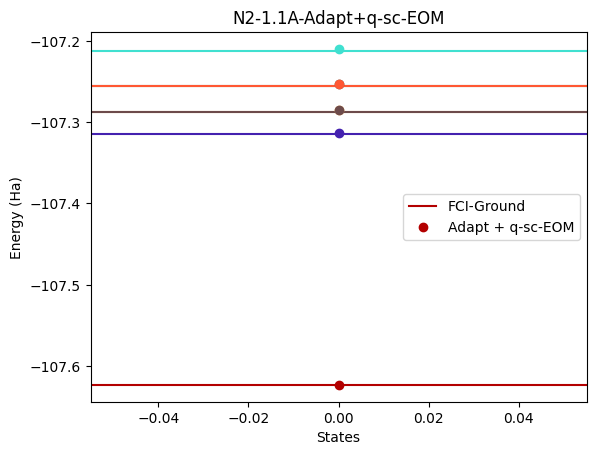

In [7]:
import matplotlib.pyplot as plt





plt.axhline(y=fenergies11[0], color="#b30000", linestyle='-', label='FCI-Ground')
plt.axhline(y=fenergies11[1], color="#4421af", linestyle='-')
plt.axhline(y=fenergies11[2], color="#ffb55a", linestyle='-')
plt.axhline(y=fenergies11[3], color="#6d4b4b", linestyle='-')
plt.axhline(y=fenergies11[4], color="#466964", linestyle='-')
plt.axhline(y=fenergies11[5], color="#FF5733", linestyle='-')
plt.axhline(y=fenergies11[6], color="#40E0D0", linestyle='-')

plt.plot(0, energy11[0],'o', color = '#b30000', label = 'Adapt + q-sc-EOM') 
plt.plot(0, energy11[1], 'o', color = '#4421af')
plt.plot(0, energy11[2], 'o', color = '#ffb55a')
plt.plot(0, energy11[3], 'o', color = '#6d4b4b')
plt.plot(0, energy11[4], 'o', color = '#466964')
plt.plot(0, energy11[5], 'o', color = '#FF5733')
plt.plot(0, energy11[6], 'o', color = '#40E0D0')


#plt.plot(1, ccsd_35_35n[5], 'v', color = '#40E0D0')

plt.legend()
#plt.ylim(-55.20, -55.10)
plt.xlabel('States')
plt.ylabel('Energy (Ha)')
plt.title('N2-1.1A-Adapt+q-sc-EOM')

plt.show()